<center><h1>Neural Episodic Critic</h1></center>
<hr>

## Introduction & Idea: Using a DND for $V(s)$ estimation

In the paper [Neural Episodic Control (NEC)](https://arxiv.org/abs/1703.01988), the authors used a memory based function approximator called differentiable neural dictionary (DND) to estimate $Q(s, a)$. This is in contrast to other work in Q-learning which uses a neural network. The DND was shown to improve sample efficiency in low data regimes.

We want to extend the idea of the DND and try to use it in a different setting, also with the hope of improving sample efficiency. Specifically, we will be looking at policy gradient methods.

Modern policy gradient methods use the output $V(s)$ of a value network called critic and subtract it from the estimate $Q(s, a)$ to get the advantage function $A(s, a)$. The value network might also additionally be used to facilitate things like N-steps estimates instead of Monte-Carlo estimates by bootstrapping from some state. In general the critic is used to reduce variance, though it may come at the cost of bias. If used correctly, it can improve sample efficiency.

The value $V(s)$ is usually estimated using a neural network. Similar to how the authors of NEC used a DND to estimate $Q(s, a)$, we would like to investigate whether estimating $V(s)$ with a DND might improve sample efficiency. The DND can be used in a similar way to how it was used in NEC. The big difference is that in NEC, we had one DND mapping states $s$ to $Q(s, a)$ for each action $a$. Here, we only need one DND which maps states $s$ to $V(s)$.

## Used Libraries

Since there are already (unofficial) implementations of the DND from NEC out there, we will use them. The most popular seems to be [this one](https://github.com/mjacar/pytorch-nec.git) which is an implementation in pytorch. We will be using it, so lets import the relevant modules.

In [1]:
import pytorch_nec as nec
import pytorch_nec.dnd
import pytorch_nec.utils.math_utils

import torch
import torch.nn as nn

Since we just decided on pytorch, we will also need a corresponding library for the policy gradient implementation. [Spinning Up](https://github.com/openai/spinningup) provides good implementations in pytorch coupled with good documentation so we will use it.

In [2]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

import spinup
import spinup.utils.plot

We will test our algorithm on [gym environments](https://github.com/openai/gym) and also need a few other things.

In [3]:
import gym

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import uuid
import multiprocessing
import time

## Experiment Setup

We will first need some code which allows us to easy run experiments in order to compare a neural network based critic with a DND based critic. Since Spinning Up doesn't share many abstractions across algorithms, we will need to decide on one policy gradient variant for now in order to simplify implementation. We will be using PPO which is implemented in [`spinup.algos.pytorch.ppo`](https://github.com/openai/spinningup/tree/master/spinup/algos/pytorch/ppo).

The following code sets up the basic parameters we will test our algorithm with. We will use the very simple `CartPole` environment first to make the idea work at all. Later, we will also test it on a slightly more complex environment.

In [5]:
def run_experiment(args):
    # This function is only used through multiprocessing.Pool.map which is why we need to unpack the arguments
    # 
    # seed (int): Used for making the experiment reproducible
    # num_threads (int): The number of threads we are allowed to use for our experiment
    # args_fn (function): Called with the seed, should return the arguments for ppo for this experiment
    seed, num_threads, args_fn = args
    
    data_output_dir = os.path.join('/tmp', str(uuid.uuid4()))
    
    # Set up the defaults and combine them with the explicitly given arguments
    
    default_args = {
        'env_fn': lambda: gym.make('CartPole-v1'),
        'steps_per_epoch': 500,
        'epochs': 20,
        'train_v_iters': 3,
        'seed': seed,
        'ac_kwargs': {},
        'logger_kwargs': {
            'output_dir': data_output_dir,
            'quiet': True
        },
    }
    
    ppo_args = { **default_args, **args_fn(seed) }
    if not 'hidden_sizes' in ppo_args['ac_kwargs']:
        ppo_args['ac_kwargs']['hidden_sizes'] = [64]
        
    # Call ppo and return the result
    
    warnings.filterwarnings(action = 'ignore', message = '.*Box bound precision lowered by casting to float32.*')    
    torch.set_num_threads(num_threads)
    spinup.ppo_pytorch(**ppo_args)
    return pd.concat(spinup.utils.plot.get_datasets(data_output_dir), ignore_index = True)

Due to the high variance of RL, especially in the low data region we are interested in, we need to run each experiment multiple times with different seeds. To speed this up, we will do this in parallel. The following function will run an experiment with 16 different seeds and combine the results.

In [6]:
def run_experiments(args_fn, num_experiments = 16, num_threads_per_experiment = 'auto'):
    # Try to use all the cpu cores given to us unless instructed otherwise
    # 
    # It's important to restrict pytorch with this. Otherwise by default pytorch will try to use
    # all of the cores in each process which results in hundreds / thousands of threads when run in parallel
    # and slows down the code by a lot.
    if num_threads_per_experiment == 'auto':
        num_threads_per_experiment = max(int(multiprocessing.cpu_count() / num_experiments), 1)
    
    with multiprocessing.Pool(num_experiments) as pool:
        experiment_data = pool.map(run_experiment,
            [(i + 1, num_threads_per_experiment, args_fn) for i in range(num_experiments)])
        
    return pd.concat(experiment_data)

We can then take the results from those experiments and plot them. We are mostly interested in two things.
1. The average reward of the agent, since this is what matters in the end.
2. The loss of the $V(s)$ estimate, i.e. the critic. This is the component that we are modifying, so the difference should be very visible in this plot.

In [7]:
def plot_experiments(*args):
    sns.set(style = 'darkgrid', font_scale = 1.5)
    fig, (ax1, ax2) = plt.subplots(ncols = 2)
    fig.set_figwidth(15)
    plt.subplots_adjust(wspace = 0.3)
    
    for (experiment_name, experiment_data) in args:
        sns.lineplot(x = 'Epoch', y = 'AverageEpRet', data = experiment_data, label = experiment_name, ax = ax1)
        sns.lineplot(x = 'Epoch', y = 'LossV', data = experiment_data, label = experiment_name, ax = ax2)

We can then test this method with a normal neural network based actor.

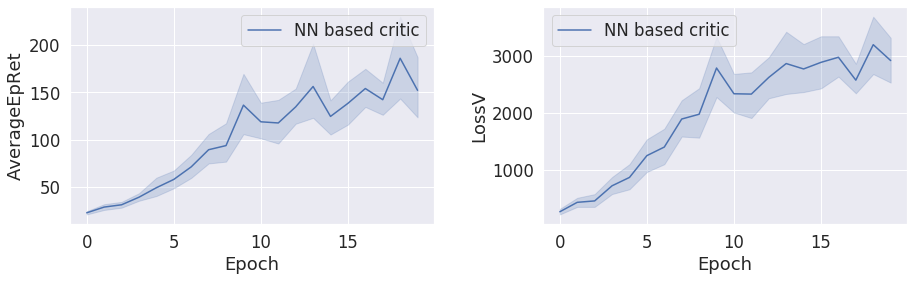

In [8]:
def create_nn_critic_experiment_data(_seed):
    return {}

nn_critic_experiment_data = run_experiments(create_nn_critic_experiment_data)

plot_experiments(('NN based critic', nn_critic_experiment_data))

As expected, the reward is going up. We can also see the loss of our $V(s)$ estimate going up. This is due to the agent getting higher rewards over time which makes estimating the exact reward harder. If trained for longer, the critic network will eventually catch up and the loss will decrease.

## Combining the DND with PPO

We now want to replace the neural network based $V(s)$ estimator with an estimator based on a DND. The $V(s)$ estimator is the critic so we will overwrite it.

In [9]:
class NECritic(nn.Module):
    def __init__(self, obs_dim, activation, embedding_size, embedding_net_sizes, dnd, obs_to_embedding):
        super().__init__()
        
        # The size of the embedding (h in the NEC paper) of observation memories which acts as a key to the DND
        self.embedding_size = embedding_size
        
        # The network which maps the observations to the embedding
        self.embedding_net = spinup.algos.pytorch.ppo.core.mlp(
            [obs_dim] + embedding_net_sizes + [embedding_size], activation)
        
        # The memory which will store our observations and associated V(s)
        self.dnd = dnd
        
        # The V(s) are calculated at the end of a trajectory (or after N steps in the NEC paper)
        # Since we have to calculate the embedding directly after seeing some state
        # but get the true corresponding V(s) only later, we store the computed embedding until then.
        self.obs_to_embedding = obs_to_embedding
    
    def forward(self, obs):
        """ Given observations `obs`, this function returns estimates of the values V(obs) """
        
        if len(obs.shape) == 1:
            # This path is used during acting, i.e. we get one observation and respond with one value.
            # Here we have to store the calculated embeddings in `obs_to_embedding` since we compute
            # them here for the first time and need them later to store the V(s) in the DND.
            return self._forward_single(obs)
        else:
            # This path is used when we are trained with the buffer after an epoch has finished.
            # We use a different path because here we don't need to store the embeddings for later use
            # since the corresponding V(s)-values are already stored in the DND. 
            return self._forward_batch(obs)
        
    def _forward_single(self, obs):
        embedding = self.embedding_net(obs).view(1, self.embedding_size)
        
        # .tostring() just gives the raw binary representation which we need because it needs to be hashable.
        #
        # Also, since we don't want to backpropagate through items stored in the DND and only through
        # the current query item, we will detach the embedding which will be stored in the DND.
        # However, it seems that even though the memories are not backpropagated through, they are trained directly.
        # See here https://github.com/EndingCredits/Neural-Episodic-Control/issues/1#issuecomment-320439287
        # We therefore need to make it a new leaf variable which is trained.
        # We do this like shown here https://pytorch.org/docs/stable/tensors.html#torch.Tensor.new_tensor
        #
        # Since the embeddings are stored in the k-d tree, we can't just adjust them without changing the k-d tree
        # We therefore have to add our code to readjust the k-d tree when the memories are trained.
        # The relevant code for this has been added to spinup.algos.pytorch.ppo.ppo.ppo()
        # and just calls dnd.update_params() during the batch V(s) learning
        self.obs_to_embedding[obs.numpy().tostring()] = embedding.clone().detach().requires_grad_(True)
        
        if self.dnd.keys is None or len(self.dnd.keys) == 1:
            # The DND is empty or contains just one element which is also problematic. We are at the beginning.
            # We will return this value and act randomly until we get some more data.
            #
            # This value might look weird but it has to be a tensor which needs to be detachable
            # and always zero so that it is similar to no baseline.
            # This is one way to create a dummy variable with these properties.
            return torch.tensor([0.0], requires_grad = True) * 0
        else:
            # The DND will return a weighted average of V(s)'s associated with similar memories to the embedding
            return self.dnd.lookup(embedding)
        
    def _forward_batch(self, obs):
        # This would mean that we would be trained even though we have nothing in our DND.
        # It could happen if our epoch is short enough and we have not committed any entries to the
        # DND yet. However, training with this would make no sense so we should make sure
        # that the numbers are large enough s.t. this does not happen.
        assert self.dnd.keys is not None and len(self.dnd.keys) > 1
        
        embeddings = self.embedding_net(obs).view(-1, self.embedding_size)
        return torch.cat([self.dnd.lookup(embedding.view(1, self.embedding_size)) for embedding in embeddings])
    
    def parameters(self):
        # The DND and the embedding network will share the gradient calculation but will
        # be trained with separate optimizers. The reason for this seems to be that this allows
        # to train the memories and network with different learning rates.
        # We will therefore make sure to not return the parameters of the DND
        # and only of the embedding network for training with the normal PPO optimizer.
        return self.embedding_net.parameters()

Since spinup combines the actor and critic in one class which can be given to the policy, we will also overwrite this. It's almost the same as the normal MLPActorCritic which uses a NN as a critic. The difference is just that we use a DND based critic and forward the corresponding arguments.

In [10]:
class NEActorCritic(spinup.algos.pytorch.ppo.core.MLPActorCritic):
    def __init__(self, observation_space, action_space, 
            hidden_sizes = (64, 64), activation = nn.Tanh, **critic_kwargs):
        super().__init__(observation_space, action_space, hidden_sizes, activation)
        
        obs_dim = observation_space.shape[0]
        self.v = NECritic(obs_dim, activation, **critic_kwargs)

In the critic, we looked up values in the DND. However, we have not yet written the code to store them there. Since this happens at the end of a trajectory, it is separate from the critic. One option would be to overwrite the policy but it turns out that the policy uses a buffer and stores all its data in there. It also calls the buffers `finish_path` method at the end of a trajectory where we can then store the $V(s)$ values.

Since the policy only takes a class (and not an instantiated class), we will have to attach the DND to the buffer in some other way. While we could again change the policy, the following takes less code even though it may be a bit hacky. Here, we are attaching the DND by wrapping the class in another function which takes the DND as argument. Since this class is also where we store $V(s)$ in the DND, we will also need to retrieve the embeddings computed in the critic, so we also take the `obs_to_embedding` dictionary where the critic writes the computed embeddings to as argument.

In [11]:
def ppo_buffer_with_attached_dnd(dnd, obs_to_embedding):
    class PPOBufferWithAttachedDND(spinup.algos.pytorch.ppo.ppo.PPOBuffer):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)

            # See last comment in the following finish_path() for how this is used.
            self.uncommitted_entries = 0

        def finish_path(self, last_val = 0):
            # This function is called at the end of a trajectory
            # or when a trajectory is interrupted by an episode finish
            # in which case last_val will be the value estimate of the last state

            # In the original implementation, the rewards-to-go, i.e. targets for value function
            # are calculated at the end and stored in self.ret_buf[slice(self.path_start_idx, self.ptr)]
            # so that's what we will use and store in the DND.

            # Since the original finish_path() function sets self.path_start_idx,
            # we will need to calculate the relevant part before calling it
            path_slice = slice(self.path_start_idx, self.ptr)
            path_length = self.ptr - self.path_start_idx

            # Then we call the function to calculate the value targets
            super().finish_path(last_val)

            # Next we use those values and store them with the associated observations in the DND
            values = self.ret_buf[path_slice]
            observations = self.obs_buf[path_slice]
            for obs, val in zip(observations, values):
                dnd.insert(
                    key = obs_to_embedding[obs.astype(np.float32).tostring()],
                    value = torch.tensor(val).view(1, 1))

            # Since we just used all the embeddings in here,
            # we don't need them anymore and remove them to save memory
            obs_to_embedding.clear()

            # A k-d tree is designed for initial building and then query, not for many intermediate updates.
            #
            # None of scipy, sklearn and the FLANN bindings have methods to add or remove a single entry.
            # See also here https://stackoverflow.com/questions/17817889 for sklearn
            # and here https://github.com/mjacar/pytorch-nec/issues/3 for the FLANN bindings.
            #
            # pytorch-nec splits adding new entries into dnd.insert() which just adds them to an array
            # and dnd.commit_insert() which rebuilds the whole k-d tree with the newly added values.
            # Since rebuilding is expensive, we only do this every N entries.
            self.uncommitted_entries += path_length
            if self.uncommitted_entries >= 300:
                dnd.commit_insert()
                self.uncommitted_entries = 0
                
    return PPOBufferWithAttachedDND

After having defined our custom Critic and associated ActorCritic, we can now use it to run the same experiment as before and compare the results.

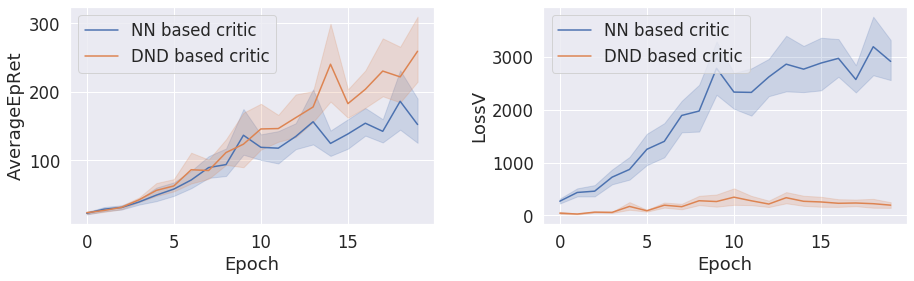

In [12]:
def create_ne_critic_experiment_data(seed):
    dnd = nec.dnd.DND(
        seed = seed,
        kernel = nec.utils.math_utils.inverse_distance,
        num_neighbors = 50,
        max_memory = 500_000,
    
        # Since the memories are trained with a separate optimizer,
        # we also need to specify the learning rate for it.
        lr = 1e-5)

    obs_to_embedding = {}
    
    return {
        'actor_critic': NEActorCritic,
        'buffer': ppo_buffer_with_attached_dnd(dnd, obs_to_embedding),
        'dnd': dnd,
        'ac_kwargs': {
            'embedding_size': 10,
            'embedding_net_sizes': [16],
            'obs_to_embedding': obs_to_embedding,
            'dnd': dnd
        }
    }

ne_critic_experiment_data = run_experiments(create_ne_critic_experiment_data)

plot_experiments(('NN based critic', nn_critic_experiment_data), ('DND based critic', ne_critic_experiment_data))

We can see that the DND based critic outperforms the NN based critic. While the reward is not that much larger, it is significant, since we ran the experiment with 16 different seeds. Looking at the LossV plot, the difference is very large and we can see that the DND outperforms the NN by a lot at estimating $V(s)$.

However, so far we have only tried the very simple `CartPole` environment and only one set of hyperparameters. In order to see under which circumstances the DND outperforms the NN, we will need to do more experiments with different parameters and environments. The following code makes it possible for us to easily do a comparison between the two algorithms on some environment and parameters, i.e. the same we did above but more structured.

In [13]:
# We need to create separate classes instead of just using a closure.
# The reason for this is that python pickle can not serialize closures,
# but we need to serialize them for use with multiprocessing.

class CreateNNCriticExperimentDataForComparison:
    def __init__(self, nn_hyperparams):
        self.nn_hyperparams = nn_hyperparams
        
    def __call__(self, seed):
        return self.nn_hyperparams

class CreateDNDCriticExperimentDataForComparison:
    def __init__(self, dnd_hyperparams):
        self.dnd_hyperparams = dnd_hyperparams

    def __call__(self, seed):
        dnd = nec.dnd.DND(
            seed = seed,
            kernel = nec.utils.math_utils.inverse_distance,
            num_neighbors = self.dnd_hyperparams['dnd_num_neighbors'],
            max_memory = self.dnd_hyperparams['dnd_max_size'],
            lr = self.dnd_hyperparams['dnd_learning_rate'])

        obs_to_embedding = {}
        
        dnd_hyperparams_cp = self.dnd_hyperparams.copy()
        for e in ['dnd_embedding_size', 'dnd_max_size', 'dnd_learning_rate',
                  'dnd_num_neighbors', 'dnd_embedding_network_size']:
            del dnd_hyperparams_cp[e]

        return {
            **dnd_hyperparams_cp,
            'actor_critic': NEActorCritic,
            'buffer': ppo_buffer_with_attached_dnd(dnd, obs_to_embedding),
            'dnd': dnd,
            'ac_kwargs': {
                'embedding_size': self.dnd_hyperparams['dnd_embedding_size'],
                'embedding_net_sizes': self.dnd_hyperparams['dnd_embedding_network_size'],
                'obs_to_embedding': obs_to_embedding,
                'dnd': dnd,
                'hidden_sizes': self.dnd_hyperparams['ac_kwargs']['hidden_sizes']
            }
        }
    
class CreateEnvFunctionForComparison:
    def __init__(self, env_name):
        self.env_name = env_name
        
    def __call__(self):
        return gym.make(self.env_name)

def compare_nn_vs_dnd(shared_hyperparams, nn_hyperparams, dnd_hyperparams):
    """
    Runs a number of experiments both with a NN critic and a DND critic and compares the results.
    Returns a plot similar to the one from before with the results.
    Also prints the time it took for the NN and DND experiments respectively.
    """
    
    nn_hyperparams = { **shared_hyperparams, **nn_hyperparams }
    dnd_hyperparams = { **shared_hyperparams, **dnd_hyperparams }
    
    # We introduce, rename and restructure how some parameters are given.
    # This makes it more obvious to see the relevant parameters when looking at the function call.
    # Because of this, the code might seem a bit messy.
    # But all it really does is just change how the parameters are given.
    
    for hyperparams in [nn_hyperparams, dnd_hyperparams]:
        hyperparams['env_fn'] = CreateEnvFunctionForComparison(hyperparams['env'])
        del hyperparams['env']
        
        hyperparams['ac_kwargs'] = { 'hidden_sizes': hyperparams['ac_network_sizes'] }
        del hyperparams['ac_network_sizes']
        
    num_seeds_nn = nn_hyperparams['num_seeds']
    num_seeds_dnd = dnd_hyperparams['num_seeds']
    
    del nn_hyperparams['num_seeds']
    del dnd_hyperparams['num_seeds']
    
    num_threads_per_seed_nn = nn_hyperparams['num_threads_per_seed']
    num_threads_per_seed_dnd = dnd_hyperparams['num_threads_per_seed']
    
    del nn_hyperparams['num_threads_per_seed']
    del dnd_hyperparams['num_threads_per_seed']
    
    # Run both experiments with NN and with DND. Measure the respective times.
    
    t1 = time.time()
    nn_critic_experiment_data = run_experiments(
        CreateNNCriticExperimentDataForComparison(nn_hyperparams),
        num_experiments = num_seeds_nn,
        num_threads_per_experiment = num_threads_per_seed_nn)
    t2 = time.time()
    dnd_critic_experiment_data = run_experiments(
        CreateDNDCriticExperimentDataForComparison(dnd_hyperparams),
        num_experiments = num_seeds_dnd,
        num_threads_per_experiment = num_threads_per_seed_dnd)
    t3 = time.time()
    
    # Return the results as plot and also print the execution times.
    
    plot_experiments(
        ('NN based critic', nn_critic_experiment_data),
        ('DND based critic', dnd_critic_experiment_data))
    
    print('NN critic experiments took ' + str(int(t2 - t1)) + ' seconds')
    print('DND critic experiments took ' + str(int(t3 - t2)) + ' seconds')

The following function then sets defaults for experiments which can be overwritten. They are almost the same as before but in a more structured form so that it is more obvious what we are executing and overwriting.

In [14]:
def compare_with_defaults_overwrite(shared_hyperparams, nn_hyperparams, dnd_hyperparams):
    default_shared_hyperparams = {
        'env': 'CartPole-v1',
        'steps_per_epoch': 500,
        'epochs': 20,
        'train_v_iters': 3,
        'ac_network_sizes': [64],
        'num_seeds': 16,
        'num_threads_per_seed': 1
    }
    
    default_nn_hyperparams = {}
    
    default_dnd_hyperparams = {
        'dnd_embedding_size': 10,
        'dnd_max_size': 500_000,
        'dnd_learning_rate': 1e-5,
        'dnd_num_neighbors': 50,
        'dnd_embedding_network_size': [16]
    }
    
    compare_nn_vs_dnd(
        { **default_shared_hyperparams, **shared_hyperparams },
        { **default_nn_hyperparams, **nn_hyperparams },
        { **default_dnd_hyperparams, **dnd_hyperparams })

Given this base, we can now run a number of experiments. First, we will use the defaults from above.

NN critic experiments took 9 seconds
DND critic experiments took 757 seconds


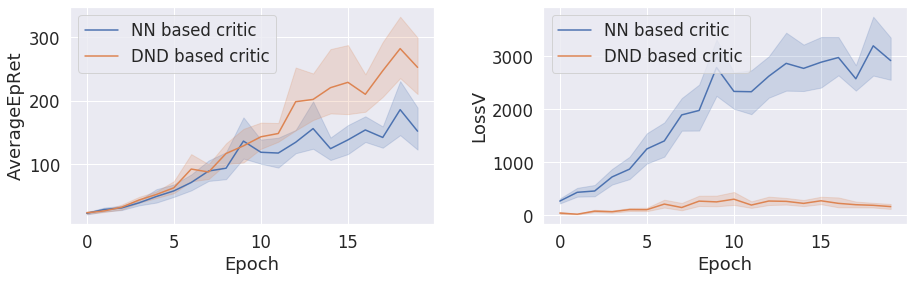

In [15]:
compare_with_defaults_overwrite({}, {}, {})

As expected, this gives us similar results to before. However, here we also measured the time it took for the experiments to finish. We note that the DND based approximator takes a lot longer. This is due to the computational expensive k-d tree. In order to do a fair comparison, we will allow the NN critic to take similar amounts of computation. One way to improve the NN is to train it more often on data from the replay buffer.

NN critic experiments took 10 seconds
DND critic experiments took 733 seconds


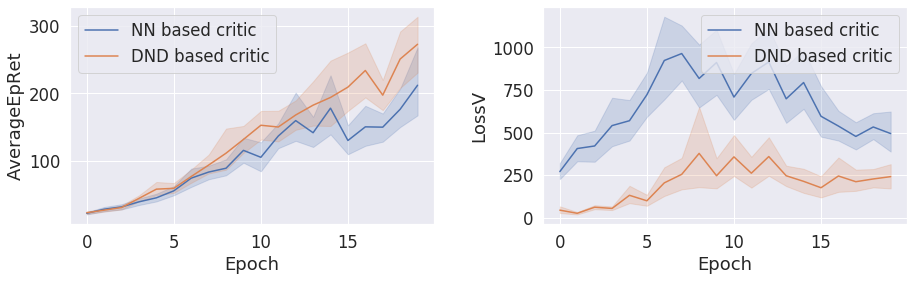

In [16]:
compare_with_defaults_overwrite({}, { 'train_v_iters': 50 }, {})

We can see that this reduces the LossV of the NN by a lot while not even taking much longer. Since a time of 733 seconds is not really acceptable for an easy environment like `CartPole`, we will next try to bring down the computation time for the DND based approach. We do this by reducing the number of neighbours used for estimating $V(s)$. 

NN critic experiments took 10 seconds
DND critic experiments took 92 seconds


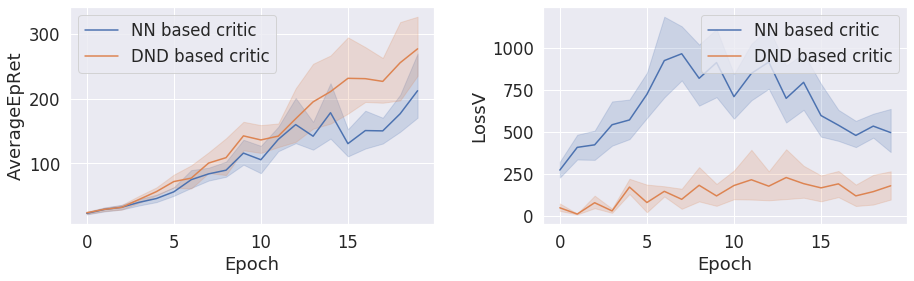

In [17]:
compare_with_defaults_overwrite({}, { 'train_v_iters': 50 }, { 'dnd_num_neighbors': 5 })

We can see that this improves performance significantly while not having a significant effect on the results. However, the NN is still a lot faster than the DND, so we allow even more computation by increasing the number of iterations the $V(s)$ network is trained from the replay buffer even more.

NN critic experiments took 22 seconds
DND critic experiments took 94 seconds


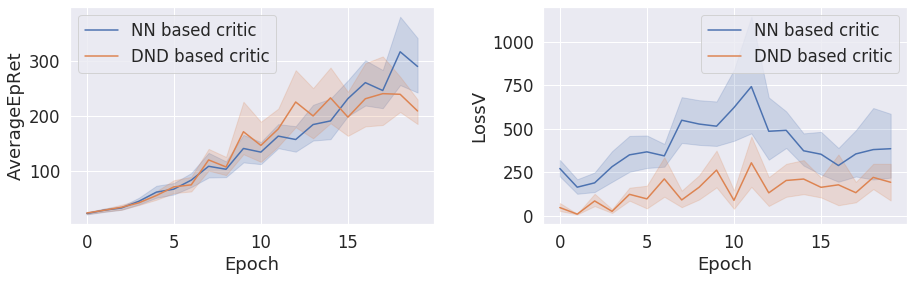

In [18]:
compare_with_defaults_overwrite({}, { 'train_v_iters': 500 }, { 'dnd_num_neighbors': 5 })

We can see that this improves the NN again a bit more so that the two different critics are not that different anymore. We can therefore see that at least on this environment with these parameters, the DND doesn't really outperform the NN once one takes computation time into account and allows the NN to be trained for more iterations. We note and criticize that this is something the [Neural Episodic Control](https://arxiv.org/abs/1703.01988) paper did not talk about. Additionally, the authors only seemed to compare against algorithms which were optimized for 200M frames but evaluated them on a lot less frames. We argue that in order to make a fair comparison, it is important to also optimize the algorithm compared to. This includes hyperparameters and also accounting for equal computation time  like done here. This is something that has also been argued about in [When to use parametric models in reinforcement learning?](https://arxiv.org/abs/1906.05243)

Since `CartPole` is a very easy environment, we will now test on a more complex one. Since a single trajectory takes longer here, we will also need to increase the episode length to finish them.

NN critic experiments took 153 seconds
DND critic experiments took 3327 seconds


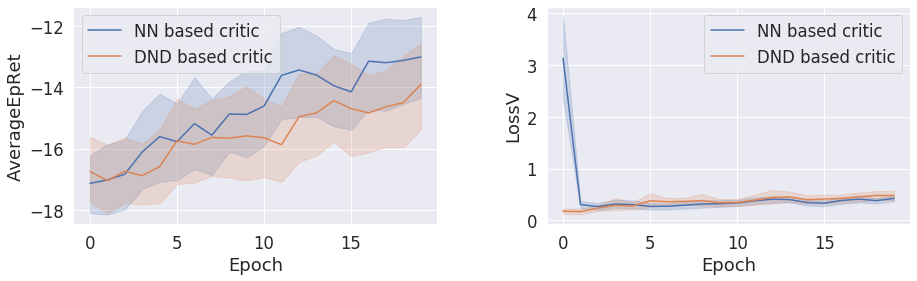

In [19]:
compare_with_defaults_overwrite(
    { 'env': 'Pong-ram-v0', 'steps_per_epoch': 5000 },
    { 'train_v_iters': 50 },
    { 'dnd_num_neighbors': 5 })

Here we can see that even with significantly more computation time, the DND does not really outperform the NN. When looking at the LossV, one can see that it does in the beginning where almost no data is available but the NN catches up pretty fast. Since we are interested whether the DND could outperform the NN on this environment, we will try to change the parameters. First of all, since the input dimension is now larger, we will try to change the sizes of the NNs used, i.e. both actor and critic.

NN critic experiments took 166 seconds
DND critic experiments took 3520 seconds


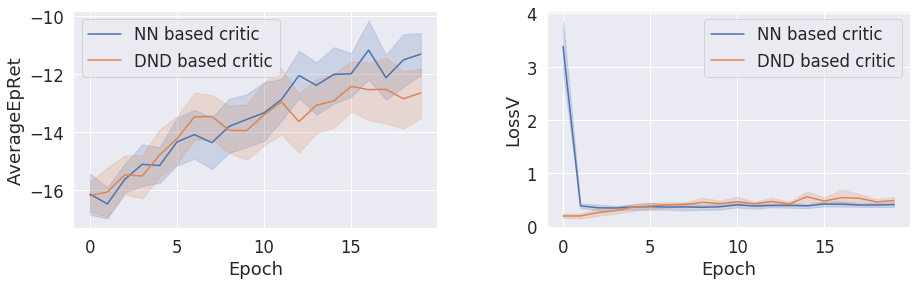

In [20]:
compare_with_defaults_overwrite(
    { 'env': 'Pong-ram-v0', 'steps_per_epoch': 5000, 'ac_network_sizes': [64, 32] },
    { 'train_v_iters': 50 },
    { 'dnd_num_neighbors': 5 })

While the results are better (the expected reward is higher), this is true for both methods and the DND does not outperform the NN. We will therefore next try to change the DND by changing the network which embeds the observations.

NN critic experiments took 165 seconds
DND critic experiments took 3398 seconds


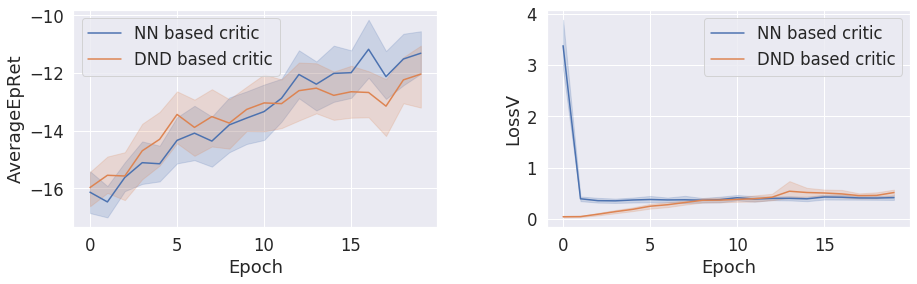

In [21]:
compare_with_defaults_overwrite(
    { 'env': 'Pong-ram-v0', 'steps_per_epoch': 5000, 'ac_network_sizes': [64, 32] },
    { 'train_v_iters': 50 },
    { 'dnd_num_neighbors': 5, 'dnd_embedding_network_size': [64] })

Looking at the LossV plot, we can see that the DND does have a smaller loss than the NN for a longer time, so we will try to make the network larger again. 

NN critic experiments took 165 seconds
DND critic experiments took 3388 seconds


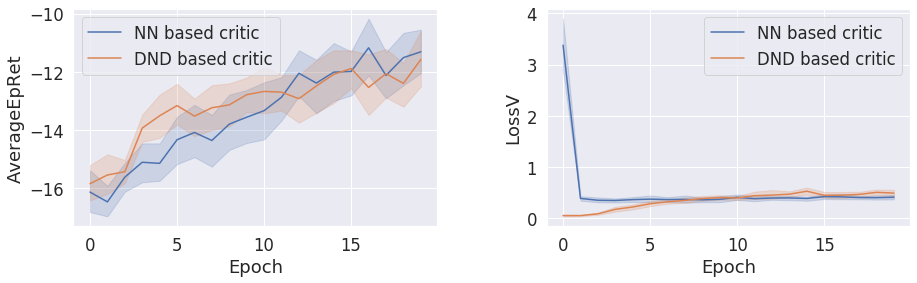

In [22]:
compare_with_defaults_overwrite(
    { 'env': 'Pong-ram-v0', 'steps_per_epoch': 5000, 'ac_network_sizes': [64, 32] },
    { 'train_v_iters': 50 },
    { 'dnd_num_neighbors': 5, 'dnd_embedding_network_size': [64, 32] })

This time, we don't get a statistically significant difference. Looking at the AverageEpRet plot, we can see that the DND outperforms the NN in the beginning a bit more than before. However, the difference isn't large and the NN quickly catches up. Given the amount of time the DND experiment took, we also believe that one could probably optimize the NN with more iterations or other things that use the computation time better than the DND.

Since the DND was not able to outperform the NN by anything else than a small difference when tested on two environments, we do not think that the idea is worth further investigation. Below, we test to change the learning rate for the DND but also don't get different results.

NN critic experiments took 168 seconds
DND critic experiments took 3232 seconds


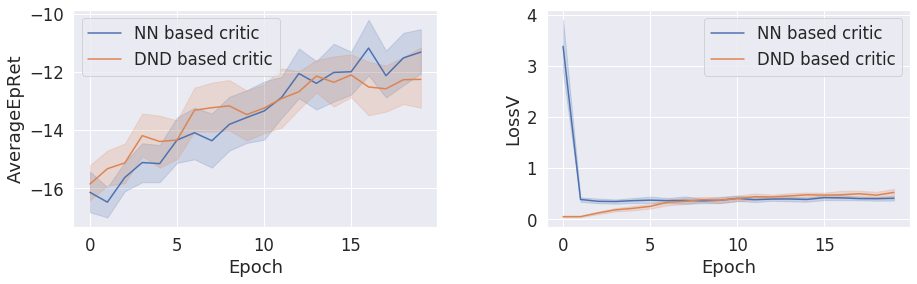

In [23]:
compare_with_defaults_overwrite(
    { 'env': 'Pong-ram-v0', 'steps_per_epoch': 5000, 'ac_network_sizes': [64, 32] },
    { 'train_v_iters': 50 },
    { 'dnd_num_neighbors': 5, 'dnd_embedding_network_size': [64, 32], 'dnd_learning_rate': 1e-4 })

NN critic experiments took 160 seconds
DND critic experiments took 3319 seconds


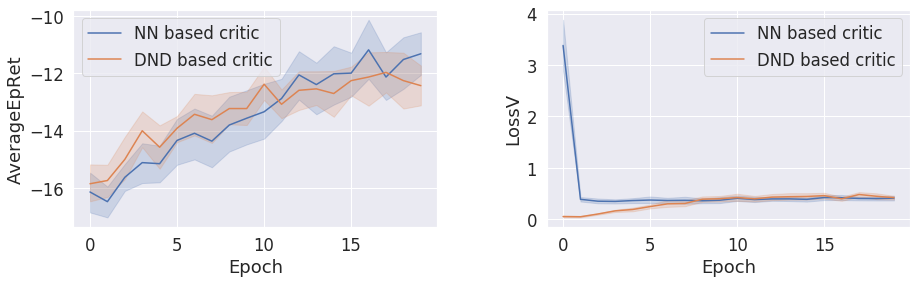

In [24]:
compare_with_defaults_overwrite(
    { 'env': 'Pong-ram-v0', 'steps_per_epoch': 5000, 'ac_network_sizes': [64, 32] },
    { 'train_v_iters': 50 },
    { 'dnd_num_neighbors': 5, 'dnd_embedding_network_size': [64, 32], 'dnd_learning_rate': 1e-6 })

## Conclusion

Our DND implementation was not able to outperform the NN by anything else than a small difference. The k-d tree needed by the DND takes a very long time to compute the neighbours which makes the critic take very long. While the DND is able to outperform the NN when using the same parameters, once the different computation time is taken into account and the NN is optimized to make use of the same computation time as the DND, the NN performs similar. We note that this is something that was not talked about in the [NEC](https://arxiv.org/abs/1703.01988) paper and criticize their seemingly unoptimized baseline used for evaluation.